# Landscape Detection - Satellite images

We are going to be using t he `Uc_merced dataset`:


* **uc_merced dataset** :
UC Merced is a 21 class land use remote sensing image dataset, with 100 images per class. The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 0.3 m.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

## Load the data and getting it ready
* We are going to load data using `tfds.load()`

In [2]:
train_data, ds_info = tfds.load(name="uc_merced", # target dataset to get from TFDS
                                shuffle_files=True, # shuffle files on download?
                                data_dir='/content/data/'
                                as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                with_info=True) # Include datasets' metadata ?


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/uc_merced/2.0.0.incompleteV0UEUK/uc_merced-train.tfrecord*...:   0%|      …

Dataset uc_merced downloaded and prepared to /root/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.


In [3]:
data = train_data['train']
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


  Image shape: (256, 256, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 12
        


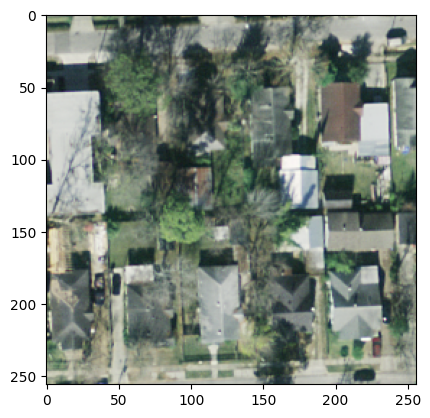

In [4]:
for image, label in data.take(1):
  plt.imshow(image)
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
        """)

### Preprocessing Data
* Convert all of them to Image Size of (256, 256, 3)
* All of the images should be normalized and on the same scale
* They should be batched and multi-threading to be introduced for better data-loading

In [5]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=256):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image/255., tf.float32), label # return (float32_image, label) tuple

# Map preprocessing function to training data (and paralellize)
data = data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
data = data.shuffle(buffer_size=2100).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
for batchX, batchY in data.take(1):
  print(batchX.shape)
  print(f'Min: {tf.reduce_min(batchX[0])} \n Max: {tf.reduce_max(batchX[0])}')

(32, 256, 256, 3)
Min: 0.0 
 Max: 1.0


In [7]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Partioning our data

In [8]:
len(data)

66

In [9]:
train_size, test_size = int(len(data)*0.8), int(len(data)*0.2)
train_size, test_size

(52, 13)

In [10]:
train_data = data.take(train_size)
test_data = data.skip(train_size).take(test_size)

In [11]:
len(train_data), len(test_data)

(52, 13)

## Setting up callbacks for Model Training
* **`Early Stopping callback`**
* **`Model Checkpoint callback`**

In [12]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            monitor='val_accuracy',
																						verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(
									    monitor="val_accuracy",
									    patience=5,
									    start_from_epoch=3
											)

## Model Experimentation
* Custom CNN model

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Flatten, Dense
from keras.layers.experimental import preprocessing

## Custom CNN model

In [15]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D((2, 2), strides=2))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=1, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(21, activation='softmax'))

In [16]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 115200)            0

In [18]:
history = model.fit(
    train_data,
    epochs=25,
    batch_size=32,
    validation_data=test_data,
    callbacks=[create_model_checkpoint(model_name='CNN_model')]
)

Epoch 1/25
52/52 [==============================] - 25s 165ms/step - loss: 3.1815 - accuracy: 0.0511 - val_loss: 3.0350 - val_accuracy: 0.0625
Epoch 2/25
52/52 [==============================] - 11s 135ms/step - loss: 3.0397 - accuracy: 0.0469 - val_loss: 2.9996 - val_accuracy: 0.1058
Epoch 3/25
52/52 [==============================] - 12s 148ms/step - loss: 2.9167 - accuracy: 0.1226 - val_loss: 2.6997 - val_accuracy: 0.1899
Epoch 4/25
52/52 [==============================] - 12s 150ms/step - loss: 2.4730 - accuracy: 0.2554 - val_loss: 1.8993 - val_accuracy: 0.4014
Epoch 5/25
52/52 [==============================] - 12s 151ms/step - loss: 1.8150 - accuracy: 0.4321 - val_loss: 1.4364 - val_accuracy: 0.5841
Epoch 6/25
52/52 [==============================] - 12s 157ms/step - loss: 1.2588 - accuracy: 0.6034 - val_loss: 0.8994 - val_accuracy: 0.7115
Epoch 7/25
52/52 [==============================] - 12s 166ms/step - loss: 0.7646 - accuracy: 0.7626 - val_loss: 0.5133 - val_accuracy: 0.8413

## Evaluating model
 * We will load the best performing model from the directory `/content/modelling_experiments/`

In [19]:
model.evaluate(test_data)

13/13 [==============================] - 6s 24ms/step - loss: 0.0266 - accuracy: 0.9952


[0.02656235173344612, 0.995192289352417]

In [20]:
model = tf.keras.models.load_model('/content/model_experiments/CNN_model/')
model.evaluate(test_data)

13/13 [==============================] - 4s 25ms/step - loss: 0.0131 - accuracy: 0.9976


[0.01314020249992609, 0.9975961446762085]

In [21]:
model.evaluate(train_data)

52/52 [==============================] - 6s 24ms/step - loss: 0.0178 - accuracy: 0.9988


[0.01781720668077469, 0.9987980723381042]

<Axes: >

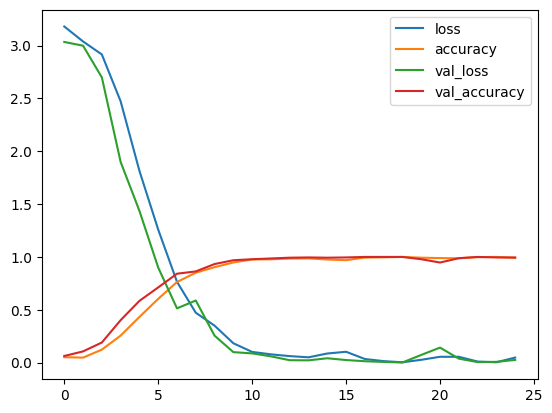

In [22]:
import pandas as pd
pd.DataFrame(history.history).plot()

## Saving the best model

In [37]:
model.save('landscape_satellite_image_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
